# Robustness Analysis: Multiplicative vs Additive Errors

This notebook compares the effectiveness of robustness optimization for multiplicative vs additive errors in quantum control. It shows how the robustness objective improves the fidelity of a desired unitary that is subject to a small error pertubation. It strucuted as follows:
* Imports
* Infidelity Comparison as a function of error

## Imports and Setup

In [1]:
using Pkg
Pkg.activate(".")
Pkg.develop(path="../../QuantumCollocation.jl")
using Revise
using QuantumCollocation
using Piccolo
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics

  Activating project at `~/Documents/research/pulses/project/notebooks/src`
   Resolving package versions...
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Project.toml`
  No Changes to `~/Documents/research/pulses/project/notebooks/src/Manifest.toml`


In [2]:
# Problem parameters
T = 50
Δt = 0.2
U_goal = GATES.H
H_drive = PAULIS.X
rob_scale = 1 / 8.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);

## Multiplicative vs Additive Error Comparison

#### Setup Problem and Solve

In [ ]:
# setup problems
# mult case

sys = QuantumSystem([H_drive])
prob = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(prob, max_iter=50, print_level=0)

rob_sys = QuantumSystem([H_drive])
rob_prob = UnitarySmoothPulseProblem(rob_sys, U_goal, T, Δt; 
H_err = H_drive, 
activate_rob_loss=true, piccolo_options=piccolo_opts)
solve!(rob_prob, max_iter=50, print_level=0)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

    initializing optimizer...
       

#### Calculate Fidelities

In [ ]:

mult_err_fids = Float64[]
additive_err_fids = Float64[]
mult_rob_fids = Float64[]
additive_rob_fids = Float64[]

error_magnitudes = [x for x in range(0.01, stop=π, length=60)]

# calculate fidelities
for ε in error_magnitudes
    println("\nError magnitude ε = $ε")

    # mult case
    H_drive_mult(ε) = (1 + ε) * H_drive
    ∂ₑHₘ = H_drive_mult(ε)
    mult_err_sys = QuantumSystem([H_drive_mult(ε)])
    mult_err_fidelity = unitary_rollout_fidelity(prob.trajectory, mult_err_sys)
    push!(mult_err_fids, mult_err_fidelity)
    mult_rob_fidelity = unitary_rollout_fidelity(rob_prob.trajectory, mult_err_sys)
    push!(mult_rob_fids, mult_rob_fidelity)

    # additive case
    ∂ₑHₐ = PAULIS.X
    H_drift(ε) = ε * PAULIS.X
    H_drive_add = PAULIS.X
    add_err_sys = QuantumSystem(H_drift(ε),[H_drive_add])
    add_err_fidelity = unitary_rollout_fidelity(prob.trajectory, add_err_sys)
    push!(additive_err_fids, add_err_fidelity)
    add_rob_fidelity = unitary_rollout_fidelity(rob_prob.trajectory, add_err_sys)
    push!(additive_rob_fids, add_rob_fidelity)
end


Error magnitude ε = 0.01

Error magnitude ε = 0.026779661016949154

Error magnitude ε = 0.043559322033898305

Error magnitude ε = 0.06033898305084746

Error magnitude ε = 0.07711864406779662

Error magnitude ε = 0.09389830508474577

Error magnitude ε = 0.11067796610169492

Error magnitude ε = 0.12745762711864406

Error magnitude ε = 0.14423728813559322

Error magnitude ε = 0.16101694915254236

Error magnitude ε = 0.17779661016949153

Error magnitude ε = 0.1945762711864407

Error magnitude ε = 0.21135593220338983

Error magnitude ε = 0.228135593220339

Error magnitude ε = 0.24491525423728813

Error magnitude ε = 0.26169491525423727

Error magnitude ε = 0.27847457627118644

Error magnitude ε = 0.2952542372881356

Error magnitude ε = 0.31203389830508477

Error magnitude ε = 0.3288135593220339

Error magnitude ε = 0.34559322033898304

Error magnitude ε = 0.3623728813559322

Error magnitude ε = 0.3791525423728814

Error magnitude ε = 0.3959322033898305

Error magnitude ε = 0.41271186440677

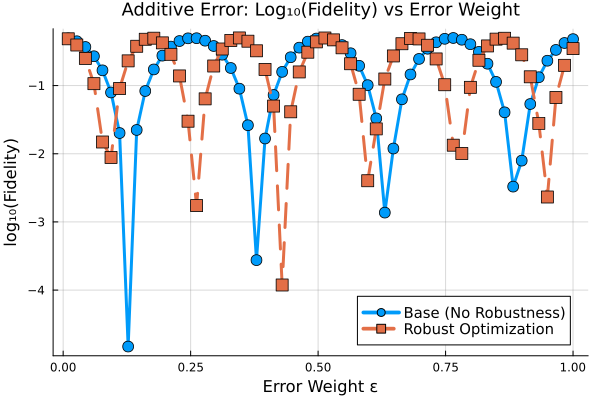

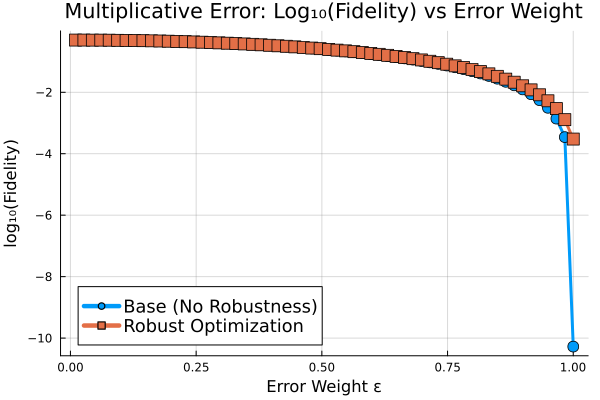


Additive Error Results:
Average base fidelity: 0.2477
Average robust fidelity: 0.2445

Multiplicative Error Results:
Average base fidelity: 0.2475
Average robust fidelity: 0.2534

 Results Table:
Error ε  | Add Err | Add Rob | Mult Err| Mult Rob %
---------------------------------------------------------------------------
   0.01 |   0.4924 |   0.4856 |    0.4999 |      0.5
 0.0268 |   0.4471 |   0.3945 |    0.4991 |   0.4996
 0.0436 |   0.3684 |   0.2507 |    0.4977 |   0.4985
 0.0603 |   0.2696 |   0.1067 |    0.4955 |   0.4967
 0.0771 |   0.1674 |   0.0149 |    0.4927 |   0.4942
 0.0939 |   0.0793 |   0.0088 |    0.4892 |   0.4911
 0.1107 |   0.0201 |   0.0907 |     0.485 |   0.4873
 0.1275 |      0.0 |   0.2307 |    0.4802 |   0.4828
 0.1442 |   0.0223 |   0.3777 |    0.4748 |   0.4778
  0.161 |   0.0833 |   0.4782 |    0.4687 |   0.4721
 0.1778 |   0.1726 |   0.4954 |     0.462 |   0.4657
 0.1946 |    0.275 |   0.4231 |    0.4547 |   0.4588
 0.2114 |   0.3732 |   0.2878 |    0.44

In [5]:
# Plot 1: Additive Error - Base vs Robust Fidelity
p1 = plot(error_magnitudes, log10.(additive_err_fids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=6, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Fidelity)",
         title="Additive Error: Log₁₀(Fidelity) vs Error Weight",
         legendfontsize=10, titlefontsize=12,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p1, error_magnitudes, log10.(additive_rob_fids), 
      label="Robust Optimization", 
      marker=:square, markersize=6, linewidth=3,
      linestyle=:dash)

# Plot 2: Multiplicative Error - Base vs Robust Fidelity
p2 = plot(error_magnitudes, log10.(mult_err_fids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=6, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Fidelity)",
         title="Multiplicative Error: Log₁₀(Fidelity) vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p2, error_magnitudes, log10.(mult_rob_fids), 
      label="Robust Optimization", 
      marker=:square, markersize=6, linewidth=3,
      linestyle=:dash)

display(p1)
display(p2)

# # plot(min_time_prob.trajectory, [:Ũ⃗, :a])

# # Summary statistics
println("\nAdditive Error Results:")
println("Average base fidelity: $(round(mean(additive_err_fids), digits=4))")
println("Average robust fidelity: $(round(mean(additive_rob_fids), digits=4))")

println("\nMultiplicative Error Results:")
println("Average base fidelity: $(round(mean(mult_err_fids), digits=4))")
println("Average robust fidelity: $(round(mean(mult_rob_fids), digits=4))")

println("\n Results Table:")
println("Error ε  | Add Err | Add Rob | Mult Err| Mult Rob %")
println("-" ^ 75)
for i in 1:length(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | $(lpad(round(additive_err_fids[i], digits=4), 8)) | $(lpad(round(additive_rob_fids[i], digits=4), 8)) | $(lpad(round(mult_err_fids[i], digits=4), 9)) | $(lpad(round(mult_rob_fids[i], digits=4), 8))")
end


## Adjoint, Toggling, Adjoint+Toggling Comparison

We setup and solve four problems:
1. Without the toggle-frame robustness objective:
    1. Additive error case 
    2. Multiplicative error case
2. With the robustness objective 
    1. Additive error case
    2. Multiplicative error case

### Base Case (without toggle-frame robustness objective)

#### Setup problem

In [10]:
# setup problems
# mult case
∂ₑHₘ = H_drive
varsys_mult = VariationalQuantumSystem([H_drive], [∂ₑHₘ])
mult_base_prob = UnitaryVariationalProblem(
    varsys_mult, U_goal, T, Δt;
    variational_scales=[rob_scale],
    robust_times=[[T]],
    piccolo_options=piccolo_opts
)

# additive case
H_drive_add = PAULIS.X
∂ₑHₐ = PAULIS.X
varsys_add = VariationalQuantumSystem([H_drive_add], [∂ₑHₐ])

# setup base case
add_base_prob = UnitaryVariationalProblem(
    varsys_add, U_goal, T, Δt;
    variational_scales=[rob_scale],
    piccolo_options=piccolo_opts
)

# solve base problems
solve!(mult_base_prob, max_iter=50, print_level=0)
solve!(add_base_prob, max_iter=50, print_level=0)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt


### Robust Case

#### Setup problem

In [11]:
# additive case
H_drive_add = PAULIS.X
varsys_add = VariationalQuantumSystem([H_drive_add], [∂ₑHₐ]) 

add_rob_prob = UnitaryVariationalProblem(
        varsys_add, U_goal, T, Δt;
        variational_scales=[rob_scale],
        H_err = H_drive_add,
        activate_rob_loss=true,
        piccolo_options=piccolo_opts
    )

solve!(add_rob_prob, max_iter=50, print_level=0)

# multiplicative case
varsys_mult = VariationalQuantumSystem([H_drive], [∂ₑHₘ])
mult_rob_prob = UnitaryVariationalProblem(
    varsys_mult, U_goal, T, Δt;
    variational_scales=[rob_scale],
    robust_times=[[T]],
    H_err = H_drive,
    activate_rob_loss=true,
    piccolo_options=piccolo_opts
)

# Multiplicative robust case
solve!(mult_rob_prob, max_iter=50, print_level=0)

    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: initial value of Ũ⃗ᵥ1
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt


#### Calculate Infidelity

In [18]:
mult_robust_infids = Float64[]
additive_robust_infids = Float64[]
mult_base_infids = Float64[]
additive_base_infids = Float64[]

error_magnitudes = [x for x in range(0.01, stop=π, length=50)]

# calculate fidelities
for ε in error_magnitudes
    println("\nError magnitude ε = $ε")

    # mult case
    H_drive_mult(ε) = (1 + ε) * H_drive
    varsys_mult_err = VariationalQuantumSystem([H_drive_mult(ε)], [∂ₑHₘ])
    mult_base_fidelity = unitary_rollout_fidelity(mult_base_prob.trajectory, varsys_mult_err)
    push!(mult_base_infids, 1 - mult_base_fidelity)

    # additive case
    H_drift(ε) = ε * PAULIS.X
    varsys_add_err = VariationalQuantumSystem(H_drift(ε), [H_drive_add], [∂ₑHₐ])
    add_base_fidelity = unitary_rollout_fidelity(add_base_prob.trajectory, varsys_add_err)
    push!(additive_base_infids, 1 - add_base_fidelity)
end

for ε in error_magnitudes
    println("\nError magnitude ε = $ε")
    
    # multiplicative robust case
    H_drive_mult(ε) = (1 + ε) * H_drive
    varsys_mult_err = VariationalQuantumSystem([H_drive_mult(ε)], [∂ₑHₘ])
    mult_rob_fidelity = unitary_rollout_fidelity(mult_rob_prob.trajectory, varsys_mult_err)
    push!(mult_robust_infids, 1 - mult_rob_fidelity)

    # Additive robust case
    H_drive_add = PAULIS.X
    H_drift(ε) = ε * PAULIS.X
    varsys_add_err = VariationalQuantumSystem(H_drift(ε), [H_drive_add], [∂ₑHₐ])
    add_rob_fidelity = unitary_rollout_fidelity(add_rob_prob.trajectory, varsys_add_err)
    push!(additive_robust_infids, 1 - add_rob_fidelity)
end




Error magnitude ε = 0.01

Error magnitude ε = 0.07391005415489374

Error magnitude ε = 0.13782010830978747

Error magnitude ε = 0.2017301624646812

Error magnitude ε = 0.26564021661957493

Error magnitude ε = 0.3295502707744687

Error magnitude ε = 0.39346032492936245

Error magnitude ε = 0.45737037908425615

Error magnitude ε = 0.5212804332391499

Error magnitude ε = 0.5851904873940437

Error magnitude ε = 0.6491005415489374

Error magnitude ε = 0.7130105957038311

Error magnitude ε = 0.7769206498587249

Error magnitude ε = 0.8408307040136186

Error magnitude ε = 0.9047407581685123

Error magnitude ε = 0.9686508123234061

Error magnitude ε = 1.0325608664782997

Error magnitude ε = 1.0964709206331935

Error magnitude ε = 1.1603809747880873

Error magnitude ε = 1.224291028942981

Error magnitude ε = 1.2882010830978747

Error magnitude ε = 1.3521111372527685

Error magnitude ε = 1.4160211914076621

Error magnitude ε = 1.479931245562556

Error magnitude ε = 1.5438412997174498

Error magn

#### Plotting

We have three plots 
1. Plots the fidelity of both the base and robust cases for additive error with respect to the weight of the error
2. Plots the fidelity of both the base and robust cases for multiplicative error with respect to the weight of the error
3. Compares the relative improvement in fidelity for the additive v multiplcative error when including robustness objective 

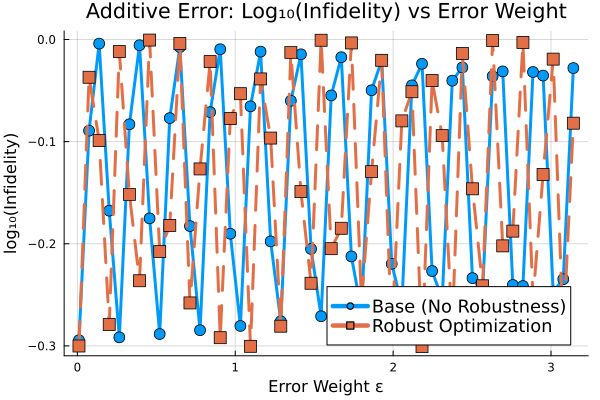

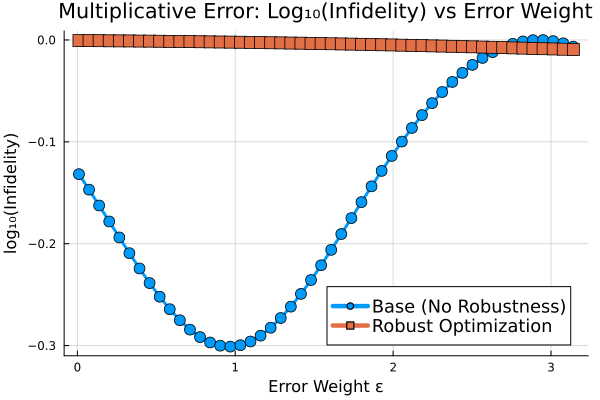

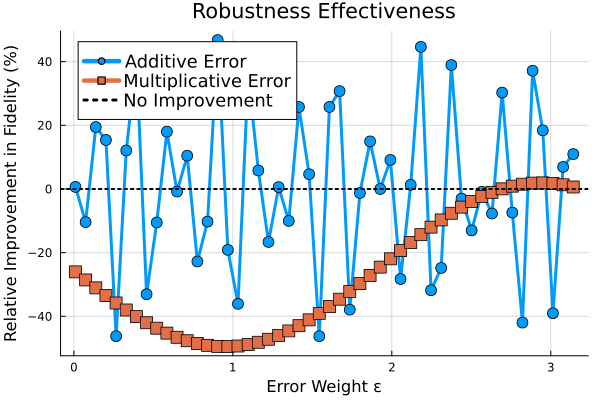


Additive Error Results:
Average base infidelity: 0.7484
Average robust infidelity: 0.7472
Average improvement: 0.12%
Max improvement: 46.78%

Multiplicative Error Results:
Average base infidelity: 0.7202
Average robust infidelity: 0.9906
Average improvement: -27.05%
Max improvement: 1.92%

Comparison:
 Additive errors benefit more from robust optimization
  Difference: 27.17% better

 Results Table:
Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%
---------------------------------------------------------------------------
   0.01 |   0.5076 |   0.5011 |      0.7 |    0.7384 |   0.9987 |     -26.0
 0.0739 |   0.8143 |   0.9184 |    -10.4 |    0.7129 |   0.9985 |     -28.6
 0.1378 |   0.9908 |   0.7963 |     19.5 |    0.6878 |   0.9984 |     -31.1
 0.2017 |   0.6798 |   0.5259 |     15.4 |    0.6634 |   0.9982 |     -33.5
 0.2656 |   0.5109 |   0.9734 |    -46.2 |    0.6399 |    0.998 |     -35.8
 0.3296 |    0.826 |   0.7052 |     12.1 |    0.6176 |   0.9978 

In [19]:
# Plot 1: Additive Error - Base vs Robust Fidelity
p1 = plot(error_magnitudes, log10.(additive_base_infids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=6, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Infidelity)",
         title="Additive Error: Log₁₀(Infidelity) vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p1, error_magnitudes, log10.(additive_robust_infids), 
      label="Robust Optimization", 
      marker=:square, markersize=6, linewidth=3,
      linestyle=:dash)

display(p1)

# Plot 2: Multiplicative Error - Base vs Robust Fidelity
p2 = plot(error_magnitudes, log10.(mult_base_infids), 
         label="Base (No Robustness)", 
         marker=:circle, markersize=6, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="log₁₀(Infidelity)",
         title="Multiplicative Error: Log₁₀(Infidelity) vs Error Weight",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3
         )

plot!(p2, error_magnitudes, log10.(mult_robust_infids), 
      label="Robust Optimization", 
      marker=:square, markersize=6, linewidth=3,
      linestyle=:dash)

display(p2)

# Calculate relative improvements
additive_improvements = [(additive_base_infids[i] - additive_robust_infids[i]) * 100 
                        for i in 1:length(error_magnitudes)]

mult_improvements = [(mult_base_infids[i] - mult_robust_infids[i]) * 100 
                    for i in 1:length(error_magnitudes)]

# Plot 3: Relative Improvement Comparison
p3 = plot(error_magnitudes, additive_improvements, 
         label="Additive Error", 
         marker=:circle, markersize=6, linewidth=3,
         xlabel="Error Weight ε", 
         ylabel="Relative Improvement in Fidelity (%)",
         title="Robustness Effectiveness",
         legendfontsize=12, titlefontsize=14,
         grid=true, gridwidth=1, gridcolor=:gray, gridalpha=0.3)

plot!(p3, error_magnitudes, mult_improvements, 
      label="Multiplicative Error", 
      marker=:square, markersize=6, linewidth=3,
      linestyle=:dash)

# Add horizontal line at 0% improvement
hline!(p3, [0], linestyle=:dot, linewidth=2, color=:black, label="No Improvement")

display(p3)


# plot(min_time_prob.trajectory, [:Ũ⃗, :a])

# Summary statistics
println("\nAdditive Error Results:")
println("Average base infidelity: $(round(mean(additive_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(additive_robust_infids), digits=4))")
println("Average improvement: $(round(mean(additive_improvements), digits=2))%")
println("Max improvement: $(round(maximum(additive_improvements), digits=2))%")

println("\nMultiplicative Error Results:")
println("Average base infidelity: $(round(mean(mult_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(mult_robust_infids), digits=4))")
println("Average improvement: $(round(mean(mult_improvements), digits=2))%")
println("Max improvement: $(round(maximum(mult_improvements), digits=2))%")

# Which error type benefits more from robustness?
avg_add_improvement = mean(additive_improvements)
avg_mult_improvement = mean(mult_improvements)

println("\nComparison:")
if avg_add_improvement > avg_mult_improvement
    println(" Additive errors benefit more from robust optimization")
    println("  Difference: $(round(avg_add_improvement - avg_mult_improvement, digits=2))% better")
else
    println(" Multiplicative errors benefit more from robust optimization")
    println("  Difference: $(round(avg_mult_improvement - avg_add_improvement, digits=2))% better")
end

println("\n Results Table:")
println("Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%")
println("-" ^ 75)
for i in 1:length(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | $(lpad(round(additive_base_infids[i], digits=4), 8)) | $(lpad(round(additive_robust_infids[i], digits=4), 8)) | $(lpad(round(additive_improvements[i], digits=1), 8)) | $(lpad(round(mult_base_infids[i], digits=4), 9)) | $(lpad(round(mult_robust_infids[i], digits=4), 8)) | $(lpad(round(mult_improvements[i], digits=1), 9))")
end
